In [1]:
import warnings

warnings.simplefilter("ignore")
import os
import re
import sys
import numpy as np
from numpy import *
import nibabel as nb
from scipy import ndimage
from matplotlib.colors import LinearSegmentedColormap
from nilearn.plotting.edge_detect import _edge_map as edge_map
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\kjlya\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
def opaque_colorscale(basemap, reference, vmin=None, vmax=None, alpha=1):
    """
    A function to return a colorscale, with opacities
    dependent on reference intensities.
    **Positional Arguments:**
        - basemap:
            - the colormap to use for this colorscale.
        - reference:
            - the reference matrix.
    """
    reference = reference
    if vmin is not None:
        reference[reference > vmax] = vmax
    if vmax is not None:
        reference[reference < vmin] = vmin
    cmap = basemap(reference)
    maxval = np.nanmax(reference)
    # all values beteween 0 opacity and 1
    opaque_scale = alpha * reference / float(maxval)
    # remaps intensities
    cmap[:, :, 3] = opaque_scale
    return cmap

def pad_im(image,max_dim,pad_val):

    """
    Pads an image to be same dimensions as given max_dim
    Parameters
    -----------
    image: 3-d RGB np array of image slice
    max_dim: dimension to pad up to
    pad_val: value to pad with
    Returns
    -----------
    padded_image: 3-d RGB np array of image slice with padding
    """
    pad_width = (((max_dim-image.shape[0])//2,(max_dim-image.shape[0])//2),((max_dim-image.shape[1])//2,(max_dim-image.shape[1])//2),(0,0))
    padded_image = np.pad(image, pad_width=pad_width, mode='constant', constant_values=pad_val)

    return padded_image

In [3]:
def plot_overlays(gm, csf, wm, cmaps=None, minthr=2, maxthr=95, edge=False):
    '''
    gm: 3d nparray of gm
    csf: 3d nparray of csf
    wm: 3d nparray of wm
    '''
    plt.rcParams.update({"axes.labelsize": "x-large", "axes.titlesize": "x-large"})
    foverlay = plt.figure()
    plt.title(f'Qa for fast \n {gm.shape} \n\n', fontsize=20)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

    if gm.shape != csf.shape:
        raise ValueError("Brains are not the same shape.")
    if cmaps is None:
        cmap1 = LinearSegmentedColormap.from_list("mycmap1", ["white", "magenta"])
        cmap2 = LinearSegmentedColormap.from_list("mycmap2", ["white", "green"])
        cmap3 = LinearSegmentedColormap.from_list("mycmap3", ["white", "blue"])
        cmaps = [cmap1, cmap2, cmap3]

    if csf.shape == (182, 218, 182):
        x = [78, 90, 100]
        y = [82, 107, 142]
        z = [88, 103, 107]
    else:
        shap = csf.shape
        x = [int(shap[0] * 0.35), int(shap[0] * 0.51), int(shap[0] * 0.65)]
        y = [int(shap[1] * 0.35), int(shap[1] * 0.51), int(shap[1] * 0.65)]
        z = [int(shap[2] * 0.35), int(shap[2] * 0.51), int(shap[2] * 0.65)]
    coords = (x, y, z)

    labs = [
        "Sagittal Slice",
        "Coronal Slice",
        "Axial Slice",
    ]
    
    
    var = ["X", "Y", "Z"]
    # create subplot for first slice
    # and customize all labels
    idx = 0
    if edge:
        min_val = 0
        max_val = 1
    else:
        min_val, max_val = get_min_max(csf, minthr, maxthr)
    for i, coord in enumerate(coords):
        for pos in coord:
            idx += 1
            ax = foverlay.add_subplot(3, 3, idx)
            ax.set_title(var[i] + " = " + str(pos))
            if i == 0:
                image = ndimage.rotate(csf[pos, :, :], 90)
                atl = ndimage.rotate(gm[pos, :, :], 90)
                inim = ndimage.rotate(wm[pos, :, :], 90)
            elif i == 1:
                image = ndimage.rotate(csf[:, pos, :], 90)
                atl = ndimage.rotate(gm[:, pos, :], 90)
                inim = ndimage.rotate(wm[:, pos, :], 90)
            else:
                image = csf[:, :, pos]
                atl = gm[:, :, pos]
                inim = wm[:, :, pos]

            if idx % 3 == 1:
                ax.set_ylabel(labs[i])
                ax.yaxis.set_ticks([0, image.shape[0] / 2, image.shape[0] - 1])
                ax.xaxis.set_ticks([0, image.shape[1] / 2, image.shape[1] - 1])
            
            
            if edge:
                image = edge_map(image).data
                image[image > 0] = max_val
                image[image == 0] = min_val
            
            plt.xticks([])
            plt.yticks([])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.imshow(atl, interpolation="none", cmap=cmaps[0], alpha=0.65)
            ax.imshow(inim, interpolation="none", cmap=cmaps[1], alpha=0.65)
            ax.imshow(image, interpolation="none", cmap=cmaps[2], alpha=0.6)
            ax.imshow(
                opaque_colorscale(
                    cmaps[0], atl, alpha=0.65, vmin=min_val, vmax=max_val
                )
            )
            ax.imshow(
                opaque_colorscale(
                    cmaps[1], inim, alpha=0.65, vmin=min_val, vmax=max_val
                )
            )
            ax.imshow(
                opaque_colorscale(
                    cmaps[2], image, alpha=0.6, vmin=min_val, vmax=max_val
                )
            )
            if idx == 3:
                plt.plot(0, 0, "-", c='green', label='wm')
                plt.plot(0, 0, "-", c='pink', label='gm')
                plt.plot(0, 0, "-", c='blue', label='csf')
                plt.legend(loc='upper right',fontsize=15,bbox_to_anchor=(1.5,1.5))
            
    foverlay.set_size_inches(12.5, 10.5, forward=True)
    foverlay.tight_layout
    return foverlay

In [4]:
def get_min_max(data, minthr=2, maxthr=95):
    """
    data: regmri data to threshold.
    """
    min_val = np.percentile(data, minthr)
    max_val = np.percentile(data, maxthr)
    return (min_val.astype(float), max_val.astype(float))

In [5]:
def reg_mri_pngs(
    csf, gm, wm, outdir, loc=0, mean=False, minthr=2, maxthr=95, edge=False):
    """
    csf: directory where csf nifity file is loaded
    gm: directory where gm nifity file is loaded
    wm: directory where wm nifity file is loaded
    outdir: directory where output png file is saved
    fname: name of output file WITHOUT FULL PATH. Path provided in outdir.
    """
    gm_data = nb.load(gm).get_data()#csf
    csf_data = nb.load(csf).get_data()#gm
    wm_data = nb.load(wm).get_data()#wm
    
    gm_data = (gm_data*255).astype(np.uint8)
    csf_data = (csf_data*255).astype(np.uint8)
    wm_data = (wm_data*255).astype(np.uint8)
    
    gm_data = pad_im(gm_data, max(gm_data.shape), 0)
    csf_data = pad_im(csf_data, max(csf_data.shape), 0)
    wm_data = pad_im(wm_data, max(wm_data.shape), 0)

    cmap1 = LinearSegmentedColormap.from_list("mycmap1", ["white", "magenta"])
    cmap2 = LinearSegmentedColormap.from_list("mycmap2", ["white", "green"])
    cmap3 = LinearSegmentedColormap.from_list("mycmap3", ["white", "blue"])

    fig = plot_overlays(gm_data, csf_data, wm_data, [cmap1, cmap2, cmap3], minthr, maxthr, edge)

    # name and save the file
    fname = os.path.split(csf)[1].split(".")[0] + ".png"
    fig.savefig(outdir + "/" + fname, format="png")
    #plt.close()

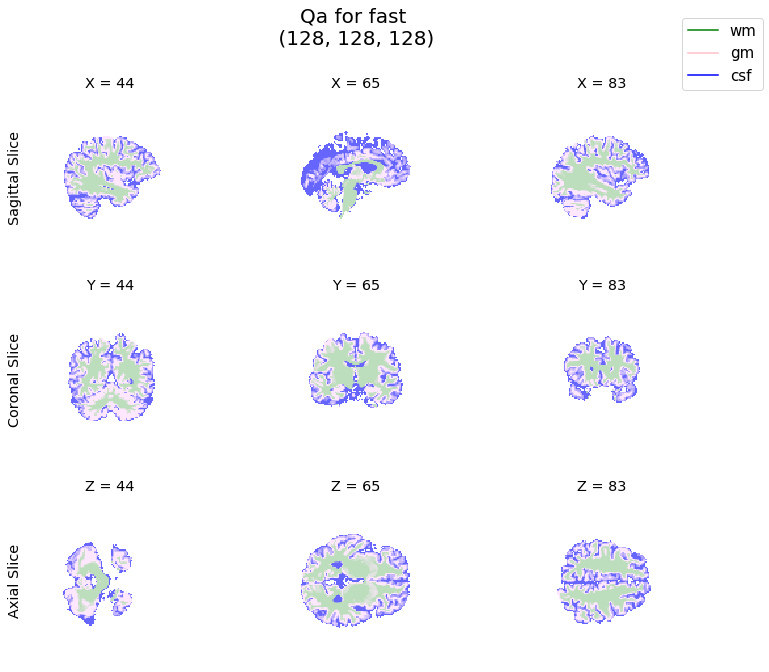

In [6]:
input_1 = 'd:/Downloads/neurodatadesign/output_data/flirt/sub-0025864/ses-1/anat/preproc/t1w_seg_pve_0.nii.gz'#csf
input_2 = 'd:/Downloads/neurodatadesign/output_data/flirt/sub-0025864/ses-1/anat/preproc/t1w_seg_pve_1.nii.gz'#gm
input_3 = 'd:/Downloads/neurodatadesign/output_data/flirt/sub-0025864/ses-1/anat/preproc/t1w_seg_pve_2.nii.gz'#wm
output_dir = "e:/"
reg_mri_pngs(input_1, input_2, input_3, output_dir)